# Training with Background Data

## We wrote this code with the help of the following scripts

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Pytorch_data_to_folders.py

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Transfer_Learning_STL10.py

In [1]:
import torch, time, os, copy, random, imageio, os, shutil, numpy, zipfile
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt

In [2]:
Num_class=10
folderlocation = './data/STL10/'

def create_dir(folderlocation):
    if not os.path.exists(folderlocation):
        os.mkdir(folderlocation)
    
create_dir('./data/')
create_dir(folderlocation)
for iterf in ['train/', 'valid/', 'test/']:
    create_dir(folderlocation + iterf)
    for iter1 in range(Num_class+1): 
        create_dir(folderlocation + iterf + str(iter1)) 

create_dir('./Background/')
with zipfile.ZipFile('/kaggle/input/background-image-data/Background_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./Background/')

In [3]:
image_index = 0
for dirpath, dirnames, filenames in os.walk('./Background/'):
    for fname in filenames:        
        if image_index== 500:
            shutil.copyfile(path, folderlocation + 'valid/'+str(Num_class)+'/'+str(image_index) + fname[-9:])
            shutil.copyfile(path, folderlocation + 'test/'+str(Num_class)+'/'+str(image_index) + fname[-9:])
            #break 
        path = os.path.join(dirpath,fname)
        shutil.copyfile(path, folderlocation + 'train/'+str(Num_class)+'/'+str(image_index) + fname[-9:])
        image_index = image_index +1



In [4]:
data_train = datasets.STL10('/files/', split='train', download=True,
                             transform=transforms.Compose([ ]))
        
for iter1 in range(len(data_train)):
    x, a = data_train[iter1] 
    if iter1%10 ==0:
        imageio.imwrite(folderlocation + 'valid/'+str(a)+'/valid'+str(iter1)+'.png', x)
    else:
        imageio.imwrite(folderlocation + 'train/'+str(a)+'/train'+str(iter1)+'.png', x) 
        
data_test = datasets.STL10('/files/', split='test', download=True,
                             transform=transforms.Compose([ ]))

for iter1 in range(len(data_test)):
    x, a = data_test[iter1] 
    imageio.imwrite(folderlocation + 'test/'+str(a)+'/test'+str(iter1)+'.png', x)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /files/stl10_binary.tar.gz to /files/
Files already downloaded and verified


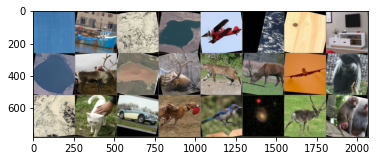

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((272,272)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(folderlocation, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = numpy.array([0.507, 0.487, 0.441])
    std = numpy.array([0.267, 0.256, 0.276])
    inp = std * inp + mean
    inp = numpy.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out)

In [6]:
model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, Num_class+1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

In [7]:
model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20) # num_epochs=20 default

Epoch 0/19
----------
train Loss: 0.7492 Acc: 0.8207
valid Loss: 0.1925 Acc: 0.9601
test Loss: 0.1541 Acc: 0.9681

Epoch 1/19
----------
train Loss: 0.1454 Acc: 0.9660
valid Loss: 0.1195 Acc: 0.9701
test Loss: 0.0883 Acc: 0.9783

Epoch 2/19
----------
train Loss: 0.0957 Acc: 0.9767
valid Loss: 0.0836 Acc: 0.9840
test Loss: 0.0586 Acc: 0.9845

Epoch 3/19
----------
train Loss: 0.0658 Acc: 0.9837
valid Loss: 0.0730 Acc: 0.9820

Epoch 4/19
----------
train Loss: 0.0564 Acc: 0.9861
valid Loss: 0.0764 Acc: 0.9800

Epoch 5/19
----------
train Loss: 0.0391 Acc: 0.9915
valid Loss: 0.0687 Acc: 0.9840

Epoch 6/19
----------
train Loss: 0.0323 Acc: 0.9935
valid Loss: 0.0675 Acc: 0.9820

Epoch 7/19
----------
train Loss: 0.0251 Acc: 0.9951
valid Loss: 0.0659 Acc: 0.9840

Epoch 8/19
----------
train Loss: 0.0246 Acc: 0.9952
valid Loss: 0.0629 Acc: 0.9860
test Loss: 0.0471 Acc: 0.9849

Epoch 9/19
----------
train Loss: 0.0251 Acc: 0.9945
valid Loss: 0.0590 Acc: 0.9860

Epoch 10/19
----------
train L

# Save Model

In [8]:
PATH = "./model_background.pt"
torch.save(model_ft.state_dict(), PATH)

'''
#Guideline for loading model in future 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.wide_resnet101_2(pretrained=False) 
        #We only need the structure to transfer parameters
        
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, Num_class)

model.load_state_dict(torch.load(PATH2, map_location=device))
'''

'\n#Guideline for loading model in future \ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nmodel = models.wide_resnet101_2(pretrained=False) \n        #We only need the structure to transfer parameters\n        \nnum_ftrs = model.fc.in_features\nmodel.fc = nn.Linear(num_ftrs, Num_class)\n\nmodel.load_state_dict(torch.load(PATH2, map_location=device))\n'

# Delete Downloaded Data
### Notebook with basic STL-10 data is saving the STL-10 data.
### We can get background data from the background dataset.

In [9]:
shutil.rmtree('./data/')